In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv('BE_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv('BE_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(53647, 18)
metadata shape:(1289, 26)


In [3]:
# plt.figure(figsize=(20,6))
# plt.plot(agg_ts.groupby('DatetimeBegin').count(), 'o', color='skyblue')
# plt.title('Nb of measurements per DatetimeBegin')
# plt.ylabel('number of measurements')
# plt.xlabel('DatetimeBegin')
# plt.show()

In [4]:
# ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
# plt.figure(figsize=(8,4))
# plt.hist(ser_avail_days.sort_values(ascending=False))
# plt.ylabel('Nb SamplingPoints')
# plt.xlabel('Nb of Unique DatetimeBegin')
# plt.title('Distribution of Samplingpoints by the Nb of available measurement days')
# plt.show()

In [5]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

NameError: name 'ser_avail_days' is not defined

In [ ]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

In [ ]:
df = df.loc['SPO-BETR223_00001_100',:]

In [ ]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

In [ ]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [ ]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

In [6]:
train = pd.read_csv('train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('test.csv', header=0, index_col=0).values.astype('float32')

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [7]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


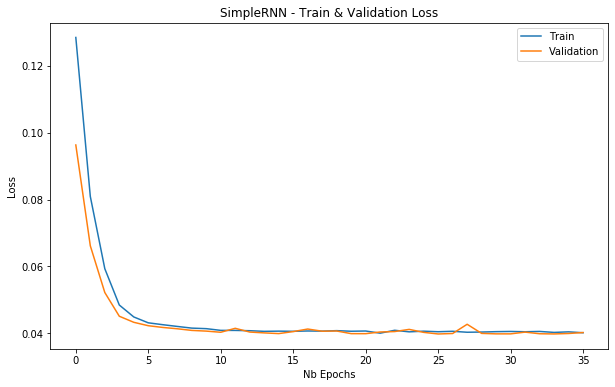

Minimum validation loss of 0.03980812701288106 reached at epoch 25


In [8]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
with open("simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen, epochs=100, validation_data=valid_data_gen, verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

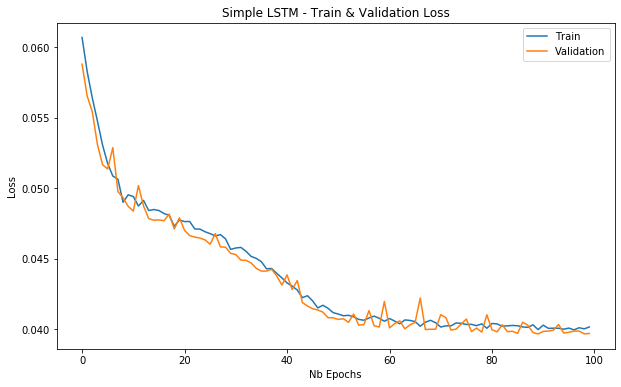

Minimum validation loss of 0.039673674624514786 reached at epoch 89


In [9]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen, epochs=100, validation_data=valid_data_gen, verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

In [10]:
def eval_best_model(model):
    # Load model architecture from JSON
    model_architecture = open(model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights(model+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mae', optimizer=RMSprop())
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')
eval_best_model('simple_lstm')

Loss on test data for simple_rnn : 0.01584779350299314
Loss on test data for simple_lstm : 0.01554339438672854
